In [73]:
# Imports para graficos
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
from collections import Counter
import os

import torch
from transformers import BertTokenizerFast, BertForSequenceClassification, Trainer, TrainingArguments, AdamW
from torch.utils.data import DataLoader, TensorDataset

from datasets import Dataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

## Análise inicial dos dados

In [74]:
# Verificar se o arquivo 'games_tratado.csv' já existe no diretório
if os.path.exists('data/games_tratado.csv'):
    # Se o arquivo existir, carregar o DataFrame do arquivo CSV
    df = pd.read_csv('data/games_tratado.csv')
    print("Arquivo 'games_tratado.csv' carregado.")
    
    # Remover aspas simples dos gêneros (se existirem)
    df['Genres'] = df['Genres'].apply(lambda x: [genre.replace("'", "") for genre in eval(x)] if isinstance(x, str) else x)

else:
    # Caso o arquivo não exista, criar e processar os dados
    df = pd.read_csv('data/games.csv')
    df = df[['AppID', 'About the game', 'Genres']]
    df = df.rename(columns={'AppID': 'Name'})

    # Dividindo os gêneros em listas e removendo as aspas simples
    df['Genres'] = df['Genres'].str.split(',')
    df['Genres'] = df['Genres'].apply(lambda x: [genre.replace("'", "") for genre in x] if isinstance(x, list) else [])

    # Salvar o DataFrame processado no arquivo
    df.to_csv('data/games_tratado.csv', index=False)
    print("Arquivo 'games_tratado.csv' criado e salvo.")

# O DataFrame 'df' agora contém os dados carregados ou processados
df_analise = df
df.head()

Arquivo 'games_tratado.csv' carregado.


,Name,About the game,Genres
0,Galactic Bowling,Galactic Bowling is an exaggerated and stylize...,"[Casual, Indie, Sports]"
1,Train Bandit,THE LAW!! Looks to be a showdown atop a train....,"[Action, Indie]"
2,Jolt Project,Jolt Project: The army now has a new robotics ...,"[Action, Adventure, Indie, Strategy]"
3,Henosis™,HENOSIS™ is a mysterious 2D Platform Puzzler w...,"[Adventure, Casual, Indie]"
4,Two Weeks in Painland,ABOUT THE GAME Play as a hacker who has arrang...,"[Adventure, Indie]"


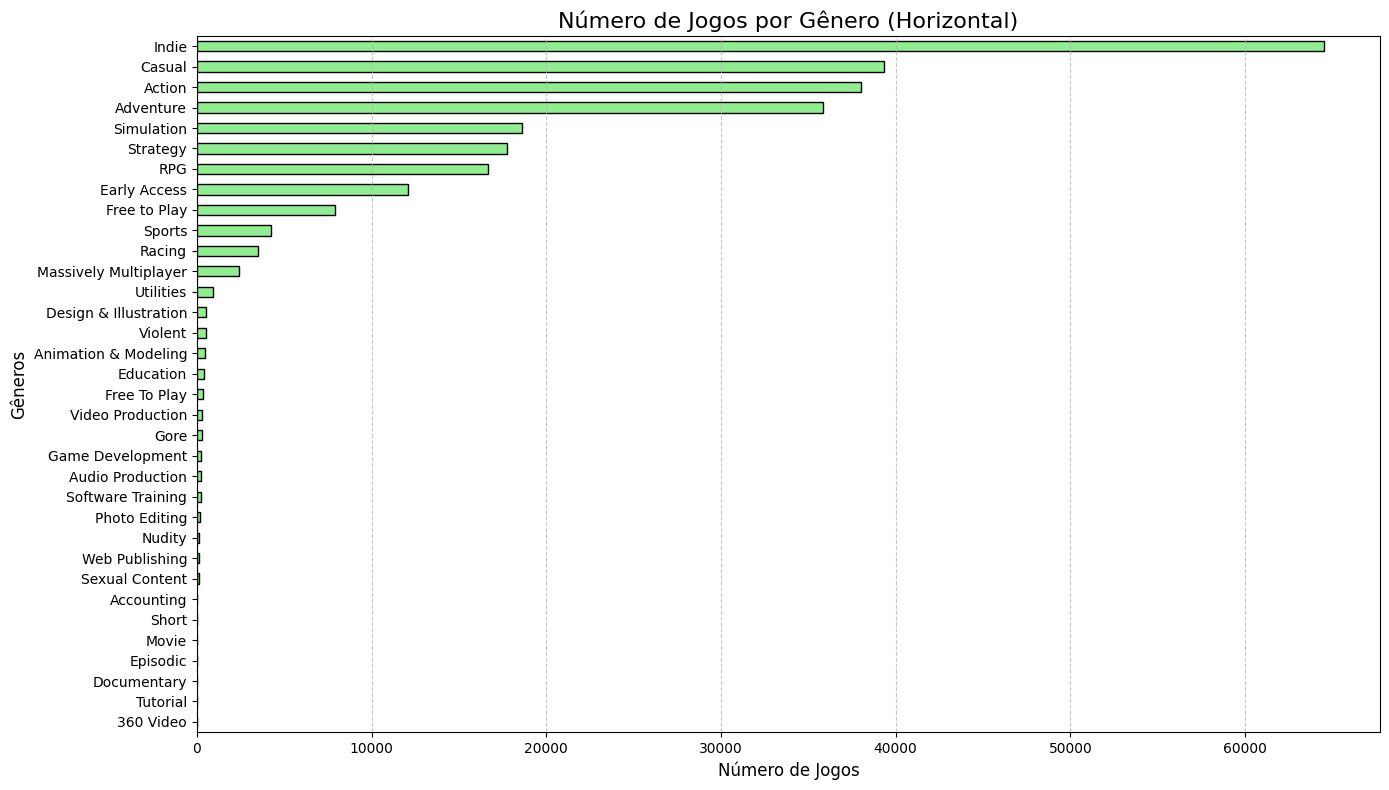

In [13]:
# Transformando cada gênero em uma linha separada
exploded_df = df_analise.explode('Genres')

# Contando o número de jogos por gênero
genre_counts = exploded_df['Genres'].value_counts()

# Plotando o gráfico de barras (horizontal) com a ordem invertida
plt.figure(figsize=(14, 8))
genre_counts[::-1].plot(kind='barh', color='lightgreen', edgecolor='black')
plt.title('Número de Jogos por Gênero (Horizontal)', fontsize=16)
plt.xlabel('Número de Jogos', fontsize=12)
plt.ylabel('Gêneros', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

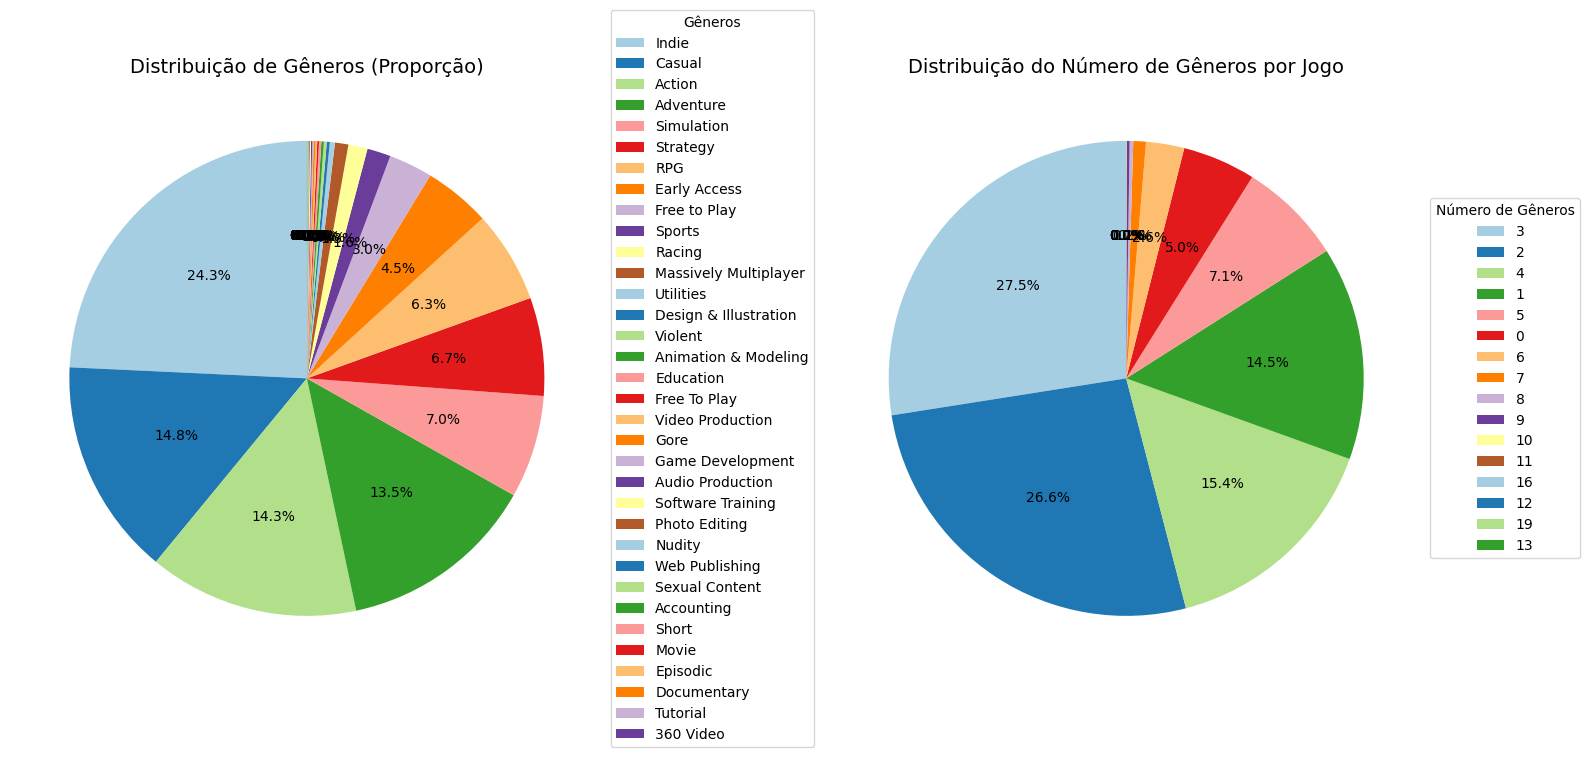

In [14]:
# Contando o número de gêneros por jogo
df_analise['Num_Genres'] = df_analise['Genres'].apply(len)

# Contando a distribuição do número de gêneros por jogo
num_genres_counts = df_analise['Num_Genres'].value_counts()

# Proporção de cada gênero
genre_proportion = genre_counts / genre_counts.sum()

# Criando os subgráficos
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Gráfico de pizza (Distribuição de Gêneros)
wedges1, texts1, autotexts1 = axes[0].pie(genre_proportion, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
axes[0].set_title('Distribuição de Gêneros (Proporção)', fontsize=14)
axes[0].set_ylabel('')  # Remover o rótulo do eixo y
axes[0].legend(wedges1, genre_proportion.index, title="Gêneros", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

# Gráfico de pizza (Distribuição do Número de Gêneros por Jogo)
wedges2, texts2, autotexts2 = axes[1].pie(num_genres_counts, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
axes[1].set_title('Distribuição do Número de Gêneros por Jogo', fontsize=14)
axes[1].set_ylabel('')  # Remover o rótulo do eixo y
axes[1].legend(wedges2, num_genres_counts.index.astype(str), title="Número de Gêneros", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.tight_layout()
plt.show()

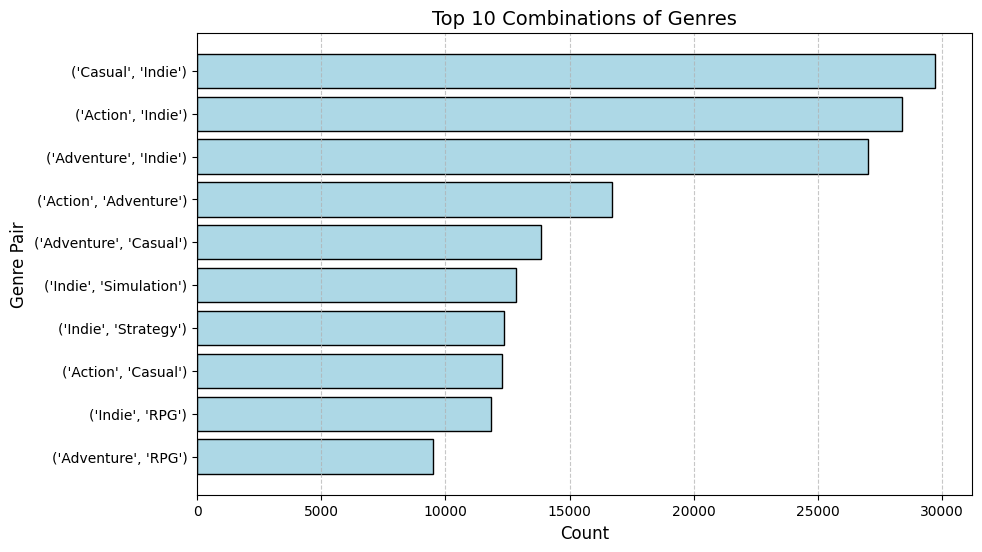

In [15]:
# Criando a lista de combinações de gêneros
genre_combinations = []
for genres in df_analise['Genres']:
    genre_combinations.extend(combinations(genres, 2))

# Contando a frequência das combinações
genre_pair_counts = Counter(genre_combinations)

# Convertendo para DataFrame e ordenando
genre_pairs_df = pd.DataFrame(genre_pair_counts.items(), columns=['Genre Pair', 'Count']).sort_values(by='Count', ascending=False)

# Selecionando as 10 combinações mais frequentes
top_combinations = genre_pairs_df.head(10)

# Criando o gráfico de barras horizontais
plt.figure(figsize=(10, 6))
plt.barh(top_combinations['Genre Pair'].astype(str), top_combinations['Count'], color='lightblue', edgecolor='black')
plt.title('Top 10 Combinations of Genres', fontsize=14)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Genre Pair', fontsize=12)
plt.gca().invert_yaxis()  # Inverter a ordem para exibir a combinação mais frequente no topo
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

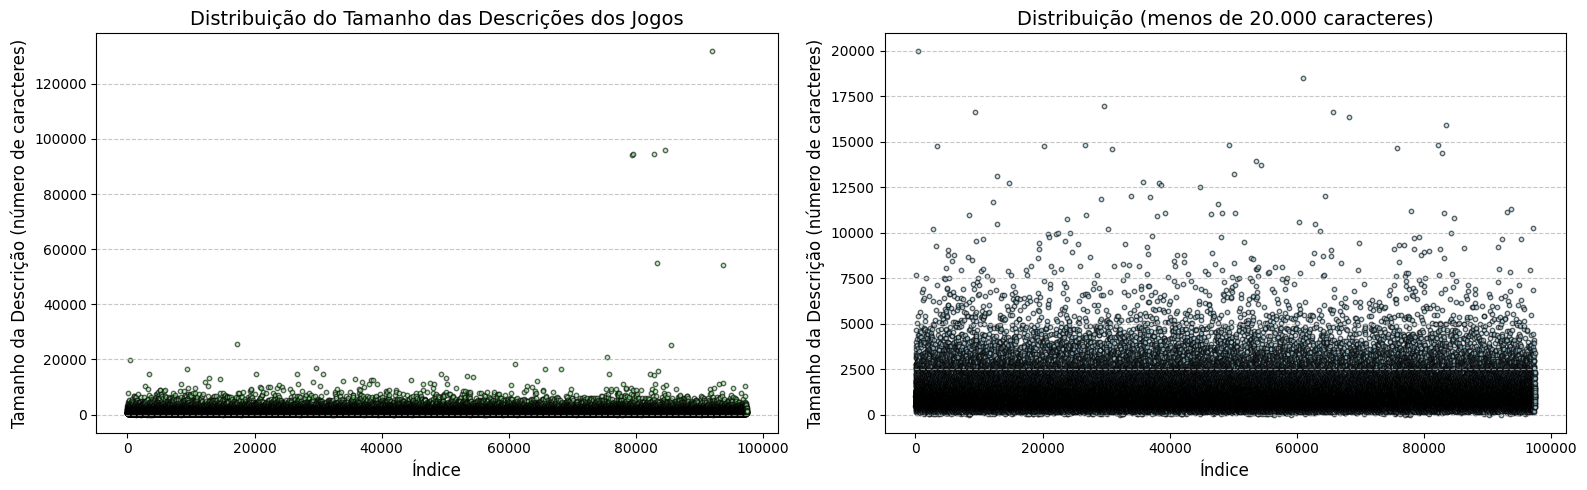

In [16]:
# Calculando o tamanho da descrição
df_analise['Description_Length'] = df_analise['About the game'].str.len()

# Criando os subgráficos
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Primeiro gráfico (todos os dados)
axes[0].scatter(df_analise.index, df_analise['Description_Length'], color='lightgreen', edgecolor='black', alpha=0.6, s=10)
axes[0].set_title('Distribuição do Tamanho das Descrições dos Jogos', fontsize=14)
axes[0].set_xlabel('Índice', fontsize=12)
axes[0].set_ylabel('Tamanho da Descrição (número de caracteres)', fontsize=12)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Segundo gráfico (apenas valores menores que 20.000 caracteres)
filtered_data = df_analise[df_analise['Description_Length'] < 20000]
axes[1].scatter(filtered_data.index, filtered_data['Description_Length'], color='lightblue', edgecolor='black', alpha=0.6, s=10)
axes[1].set_title('Distribuição (menos de 20.000 caracteres)', fontsize=14)
axes[1].set_xlabel('Índice', fontsize=12)
axes[1].set_ylabel('Tamanho da Descrição (número de caracteres)', fontsize=12)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [17]:
df_analise.head()

,Name,About the game,Genres,Num_Genres,Description_Length
0,Galactic Bowling,Galactic Bowling is an exaggerated and stylize...,"[Casual, Indie, Sports]",3,1043.0
1,Train Bandit,THE LAW!! Looks to be a showdown atop a train....,"[Action, Indie]",2,491.0
2,Jolt Project,Jolt Project: The army now has a new robotics ...,"[Action, Adventure, Indie, Strategy]",4,628.0
3,Henosis™,HENOSIS™ is a mysterious 2D Platform Puzzler w...,"[Adventure, Casual, Indie]",3,615.0
4,Two Weeks in Painland,ABOUT THE GAME Play as a hacker who has arrang...,"[Adventure, Indie]",2,672.0


# Treinamento

In [21]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from transformers import BertTokenizerFast, TrainingArguments, Trainer, BertForSequenceClassification
from torch.optim import AdamW
from torch.nn.functional import binary_cross_entropy_with_logits
from datasets import Dataset
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

import os

In [22]:
# Configurações iniciais
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_path = "./data/games_tratado.csv"

# Função para pré-processar os dados
def preprocess_data(file_path):
    """Carrega e pré-processa os dados."""
    df = pd.read_csv(file_path)
    df['Genres'] = df['Genres'].apply(lambda x: eval(x) if isinstance(x, str) else [])
    df = df.dropna(subset=['About the game', 'Genres'])
    #return df
    return df.sample(n=500, random_state=42)  # Seleciona 1.000 amostras aleatórias

# Carregar os dados
df = preprocess_data(data_path)

In [23]:
# Codificar os gêneros como multi-label
mlb = MultiLabelBinarizer()
genre_labels = mlb.fit_transform(df['Genres'])

# Divisão dos dados
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df['About the game'], genre_labels, test_size=0.5, random_state=42
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.30, random_state=42  # 60% treino, 20% validação, 20% teste
)

# Verificar tamanhos dos conjuntos
print(f"Tamanho do conjunto de treino: {len(train_texts)}")
print(f"Tamanho do conjunto de validação: {len(val_texts)}")
print(f"Tamanho do conjunto de teste: {len(test_texts)}")
print('-------------------------------------------------------------')
print('Número de gêneros únicos:', len(mlb.classes_))
print('Gêneros:', mlb.classes_)

Tamanho do conjunto de treino: 250
Tamanho do conjunto de validação: 175
Tamanho do conjunto de teste: 75
-------------------------------------------------------------
Número de gêneros únicos: 25
Gêneros: ['Action' 'Adventure' 'Audio Production' 'Casual' 'Early Access'
 'Education' 'Free To Play' 'Free to Play' 'Game Development' 'Gore'
 'Indie' 'Massively Multiplayer' 'Nudity' 'Photo Editing' 'RPG' 'Racing'
 'Sexual Content' 'Simulation' 'Software Training' 'Sports' 'Strategy'
 'Utilities' 'Video Production' 'Violent' 'Web Publishing']


In [24]:
# Inicializar o tokenizer
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

# Função para tokenizar os textos
def tokenize_function(texts):
    return tokenizer(list(texts), padding=True, truncation=True, max_length=512, return_tensors="pt")

# Tokenizar os textos
train_encodings = tokenize_function(train_texts)
val_encodings = tokenize_function(val_texts)
test_encodings = tokenize_function(test_texts)

# Criar datasets para o treinamento
def create_hf_dataset(inputs, labels):
    # Verifique se todos os arrays têm o mesmo comprimento
    assert len(inputs['input_ids']) == len(inputs['attention_mask']) == len(labels), "Mismatch in data sizes"
    return Dataset.from_dict({
        "input_ids": inputs['input_ids'].tolist(),
        "attention_mask": inputs['attention_mask'].tolist(),
        "labels": labels.tolist()
    })

train_dataset = create_hf_dataset(train_encodings, train_labels)
val_dataset = create_hf_dataset(val_encodings, val_labels)
test_dataset = create_hf_dataset(test_encodings, test_labels)


In [25]:
# Definir o modelo personalizado para classificação multi-label
class BertForMultiLabelClassification(torch.nn.Module):
    def __init__(self, model_name, num_labels):
        super(BertForMultiLabelClassification, self).__init__()
        self.bert = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        return logits

# Inicializar o modelo
num_labels = len(mlb.classes_)
model = BertForMultiLabelClassification("bert-base-uncased", num_labels).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
# Função para calcular métricas
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    print(f"Logits shape: {logits.shape}, Labels shape: {labels.shape}")  # Verifica tamanho

    # Verifica se o número de amostras é o mesmo
    if logits.shape[0] != labels.shape[0]:
        min_samples = min(logits.shape[0], labels.shape[0])
        logits = logits[:min_samples]
        labels = labels[:min_samples]

    # Converte logits em previsões binárias (0 ou 1)
    predictions = (logits > 0).astype(int)
    
    # Cálculo das métricas
    f1 = f1_score(labels, predictions, average='micro')
    precision = precision_score(labels, predictions, average='micro')
    recall = recall_score(labels, predictions, average='micro')

    # Penalizar mais os falsos positivos
    false_positives = ((predictions == 1) & (labels == 0)).sum()
    false_positives_penalty = false_positives * 2  # Aumente o multiplicador para penalizar mais
    
    return {
        "f1": f1,
        "precision": precision,
        "recall": recall,
        "false_positive_penalty": false_positives_penalty
    }
# Subclasse personalizada de Trainer
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels").to(torch.float32)  # Converte labels para float32
        outputs = model(**inputs)  # Obtém os logits do modelo
        logits = outputs

        # Calcula a perda usando BCEWithLogitsLoss
        loss = binary_cross_entropy_with_logits(logits, labels)

        return (loss, outputs) if return_outputs else loss

In [29]:
# Configurar o treinamento
training_args = TrainingArguments(
    output_dir="./training_output",
    eval_strategy="steps",
    save_strategy="steps",
    eval_steps=4,
    save_steps=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=2,
    learning_rate=5e-5,
    weight_decay=0.01,
    num_train_epochs=1,
    logging_dir="./training_output/log",
    save_total_limit=2,
    logging_steps=2,
    fp16=True,
)

# Criar o Trainer personalizado
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# Avaliar o modelo
trainer.train()

Step,Training Loss,Validation Loss,F1,Precision,Recall,False Positive Penalty
4,0.577400,0.535194,0.177559,0.201117,0.158940,572
8,0.517300,0.506494,0.310223,0.331658,0.291391,532


Logits shape: (164, 25), Labels shape: (175, 25)
Logits shape: (164, 25), Labels shape: (175, 25)


TrainOutput(global_step=8, training_loss=0.5620469897985458, metrics={'train_runtime': 204.6494, 'train_samples_per_second': 1.222, 'train_steps_per_second': 0.039, 'total_flos': 0.0, 'train_loss': 0.5620469897985458, 'epoch': 1.0})

In [30]:
print(f"Tamanho de train_texts: {len(train_texts)}")
print(f"Tamanho de train_labels: {len(train_labels)}")
print(f"Tamanho de val_texts: {len(val_texts)}")
print(f"Tamanho de val_labels: {len(val_labels)}")
print(f"Tamanho de test_texts: {len(test_texts)}")
print(f"Tamanho de test_labels: {len(test_labels)}")


Tamanho de train_texts: 250
Tamanho de train_labels: 250
Tamanho de val_texts: 175
Tamanho de val_labels: 175
Tamanho de test_texts: 75
Tamanho de test_labels: 75


In [31]:
# Salvar o modelo
def save_model(model, tokenizer, save_directory):
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)
    
    # Salvar os pesos do modelo
    torch.save(model.state_dict(), os.path.join(save_directory, "pytorch_model.bin"))
    
    # Salvar a configuração do modelo (se necessário)
    if hasattr(model, "config"):
        model.config.save_pretrained(save_directory)
    
    # Salvar o tokenizer
    tokenizer.save_pretrained(save_directory)
    
    print(f"Modelo salvo em: {save_directory}")

# Salvar o modelo
save_model(model, tokenizer, "./saved_model")

Modelo salvo em: ./saved_model


In [32]:
# Função para prever gêneros
def predict_genres(description, model, tokenizer, mlb, device, threshold=0.5):
    inputs = tokenizer(description, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
    
    # Remove token_type_ids se estiver presente
    if "token_type_ids" in inputs:
        del inputs["token_type_ids"]

    with torch.no_grad():
        outputs = model(**inputs)  # outputs já é um tensor
    
    probs = torch.sigmoid(outputs).cpu().numpy()  # Aplicar sigmoid diretamente
    predictions = (probs > threshold).astype(int)
    predicted_genres = mlb.inverse_transform(predictions)
    
    return predicted_genres[0]



# Exemplo de uso
game_name = "A Journey Through Valhalla"
description = "A Journey Through Valhalla was developed by three friends in their spare time and is by no means a AAA game. It still gives you several hours of fun and even more so if you like beating up your friends!"
predicted_genres = predict_genres(description, model, tokenizer, mlb, device)
print(f"Game Name: {game_name} || Predicted Genres: {', '.join(predicted_genres)}")


Game Name: A Journey Through Valhalla || Predicted Genres: Early Access, Strategy


In [38]:
from sklearn.metrics import precision_score, recall_score, f1_score
import csv

# Função para calcular as métricas de qualidade
def compute_quality_metrics(predicted_genres, real_genres, mlb):
    # Converter para vetores binários
    predicted_binary = mlb.transform([predicted_genres])
    real_binary = mlb.transform([real_genres])
    
    # Calcular precisão, recall, F1 e acurácia
    precision = precision_score(real_binary, predicted_binary, average='micro')
    recall = recall_score(real_binary, predicted_binary, average='micro')
    f1 = f1_score(real_binary, predicted_binary, average='micro')
    
    return precision, recall, f1

In [40]:
# Abrir o arquivo CSV em modo de escrita
with open('resultados_analise_completa.csv', mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    
    # Escrever o cabeçalho no CSV
    writer.writerow(["Game Name", "Predicted Genres", "Real Genres", "Precision", "Recall", "F1-Score", "Accuracy"])
    
    # Listas para acumular as métricas de cada jogo
    all_precisions = []
    all_recalls = []
    all_f1_scores = []
    
    for i in range(len(val_dataset)):
        # Acessa o nome do jogo e a descrição original no DataFrame
        game_name = df.iloc[i]["Name"]
        description = df.iloc[i]["About the game"]
        
        # Verificar se o valor em "Genres" é uma lista ou uma string e converter conforme necessário
        genres = df.iloc[i]["Genres"]
        if isinstance(genres, str):  # Se for string, dividir por vírgulas
            genres = [genre.strip() for genre in genres.split(",")]
        else:  # Se já for uma lista, apenas limpar os espaços
            genres = [genre.strip() for genre in genres]
        
        # Prever os gêneros
        predicted_genres = predict_genres(description, model, tokenizer, mlb, device)
        
        # Calcular as métricas, incluindo acurácia
        precision, recall, f1 = compute_quality_metrics(predicted_genres, genres, mlb)
        
        # Acumular as métricas
        all_precisions.append(precision)
        all_recalls.append(recall)
        all_f1_scores.append(f1)
        
        # Exibir os resultados
        print(f"Game Name: {game_name}")
        print(f"Predicted Genres: {', '.join(predicted_genres)}")
        print(f"Real Genres: {', '.join(genres)}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")
        print("-" * 50)
        
        # Escrever os resultados no arquivo CSV
        writer.writerow([game_name, ", ".join(predicted_genres), ", ".join(genres), 
                         round(precision, 4), round(recall, 4), round(f1, 4)])
    
    # Calcular as métricas globais (médias)
    global_precision = sum(all_precisions) / len(all_precisions)
    global_recall = sum(all_recalls) / len(all_recalls)
    global_f1 = sum(all_f1_scores) / len(all_f1_scores)
    
    # Exibir as métricas globais
    print("\nMétricas Globais:")
    print(f"Precision (Global): {global_precision:.4f}")
    print(f"Recall (Global): {global_recall:.4f}")
    print(f"F1-Score (Global): {global_f1:.4f}")
    
    # Escrever as métricas globais no CSV
    writer.writerow([])  # Linha em branco para separar
    writer.writerow(["Global Metrics", "", "", "Precision", "Recall", "F1-Score"])
    writer.writerow(["", "", "", 
                     round(global_precision, 4), round(global_recall, 4), round(global_f1, 4)])

Game Name: iOMoon
Predicted Genres: Early Access, Indie, Strategy
Real Genres: Action, Adventure, Indie, Simulation, Early Access
Precision: 0.6667
Recall: 0.4000
F1-Score: 0.5000
--------------------------------------------------
Game Name: Night Blights
Predicted Genres: Early Access, Indie, Strategy
Real Genres: Indie
Precision: 0.3333
Recall: 1.0000
F1-Score: 0.5000
--------------------------------------------------
Game Name: TouhouTraveler
Predicted Genres: Early Access
Real Genres: Action, Adventure, Indie
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
--------------------------------------------------
Game Name: Quern - Undying Thoughts
Predicted Genres: Early Access, Indie, Strategy
Real Genres: Adventure, Indie
Precision: 0.3333
Recall: 0.5000
F1-Score: 0.4000
--------------------------------------------------
Game Name: Stars Survivor
Predicted Genres: Indie, Strategy
Real Genres: Action, Free to Play
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
---------------------

c:\Users\thais\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Game Name: AVA: Dog Tag
Predicted Genres: Indie, Strategy
Real Genres: Action, Free to Play
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
--------------------------------------------------
Game Name: The American Dream
Predicted Genres: Early Access, Indie, Strategy
Real Genres: Action, Adventure, Indie
Precision: 0.3333
Recall: 0.3333
F1-Score: 0.3333
--------------------------------------------------
Game Name: Necrodome
Predicted Genres: Early Access, Indie, Strategy
Real Genres: Action, Racing
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
--------------------------------------------------
Game Name: Bargain Invaders
Predicted Genres: Early Access, Indie
Real Genres: Casual
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
--------------------------------------------------
Game Name: Drink 'Em
Predicted Genres: Early Access
Real Genres: Action, Casual, Indie
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
--------------------------------------------------
Game Name: The Im

c:\Users\thais\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Game Name: 女神之战
Predicted Genres: Early Access, Indie, Strategy
Real Genres: Casual, Strategy
Precision: 0.3333
Recall: 0.5000
F1-Score: 0.4000
--------------------------------------------------
Game Name: Piece of..Horror
Predicted Genres: Early Access
Real Genres: Adventure, Indie
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
--------------------------------------------------
Game Name: Harmonia
Predicted Genres: Early Access, Indie, Strategy
Real Genres: Adventure, Casual, Simulation
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
--------------------------------------------------
Game Name: DEMON DARK I
Predicted Genres: Early Access, Indie, Strategy
Real Genres: Action
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
--------------------------------------------------
Game Name: Detective Solitaire. Butler Story 2
Predicted Genres: Action, Indie, Strategy
Real Genres: Casual
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
--------------------------------------------------


c:\Users\thais\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Game Name: Table Football Pro
Predicted Genres: 
Real Genres: Sports, Early Access
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
--------------------------------------------------
Game Name: Requiem Aeternam Eden
Predicted Genres: Early Access
Real Genres: RPG
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
--------------------------------------------------
Game Name: The Hardest Thing Ever
Predicted Genres: Early Access
Real Genres: Adventure, Casual, Indie, Strategy
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
--------------------------------------------------
Game Name: Hum Drum Experiences
Predicted Genres: Early Access, Indie, Strategy
Real Genres: Adventure, Indie, RPG
Precision: 0.3333
Recall: 0.3333
F1-Score: 0.3333
--------------------------------------------------
Game Name: The Clot Thickens
Predicted Genres: Early Access, Indie, Strategy
Real Genres: Casual
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
--------------------------------------------------
Game N